## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
import copy
from datetime import datetime
from FireSimulator import *
from FireSimulatorUtilities import *
import glob
import itertools
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys
import time
import timeit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

## Utility functions

In [3]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() 
        return x.view(N, -1)

## Reward function

In [4]:
def eelfff_reward(traj, img_st, center):
    reward = 0
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    img_dim = img_st.shape[0]
    
    x1,y1 = traj[0]
    x2,y2 = traj[1]
    
    r = -y2 + y1 + img_dim//2
    c =  x2 - x1 + img_dim//2
    
    if img_st[r,c] in [1,2]:
        counter = 0
        for (dr,dc) in fire_neigh:
            rn = r + dr
            cn = c + dc
            if img_st[rn,cn]==0:
                counter += 1

        if counter > 0:
            reward += 1
        else:
            reward += -2   
            
    move_vec = np.array([x2-x1,y2-y1])
    if (x2-x1) != 0 and (y2-y1) != 0:
        move_vec = move_vec / np.linalg.norm(move_vec,2)
       
    cen_vec = np.array([x1-center,y1-center])
    cen_vec = cen_vec / np.linalg.norm(cen_vec,2)
    score = -1*np.cross(cen_vec,move_vec)
    
    reward += np.max([score,0]) + 2*np.min([score,0])

    return reward

## Heuristic solution
hand-tuned function to generate actions for agents

In [5]:
def heuristic(pos, img_st, seen_fire, center):

    traj = []
    actions = []
    traj.append((pos[0],pos[1]))
    img_dim = img_st.shape[0]
    fire_neigh = [(-1,0),(0,-1),(1,0),(0,1)]
    move_neigh = [(-1,0),(1,0),(-1,1),(0,1),(1,1),(-1,-1),(0,-1),(1,-1)] #excluded (0,0)
    action_set = [4,1,2,3,5,8,7,6]
    
    dists = None
    x,y = pos

    r = img_dim//2
    c = img_dim//2

    if img_st[r,c] in [1,2] or seen_fire:
        seen_fire = True
        dists = []
        
        cen_vec = np.array([x-center,y-center])
        cen_vec = cen_vec/np.linalg.norm(cen_vec)
        for a in range(1,9):
        #for a in [2,5,7,4]:
            new_pos = actions_to_trajectory(traj[-1],[a])[1]

            rl = -new_pos[1] + y + img_dim//2
            cl = new_pos[0] -x + img_dim//2
            #if a in [1,3,8,6] and img_st[rl,cl] in [0]:
            #    continue

            move_vec = np.array([new_pos[0]-x,new_pos[1]-y])
            if a != 0:
                move_vec = move_vec/np.linalg.norm(move_vec)
            dists.append((np.cross(cen_vec,move_vec),new_pos,a))

        cir_pos = min(dists)[1]
        cir_act = min(dists)[2]

        ri = -cir_pos[1] + y + img_dim//2
        ci = cir_pos[0] -x + img_dim//2

        left_act = None
        if cir_act==1:
            left_act = [6,4]
            #left_act = [4]
            righ_act = [2]
        elif cir_act==2:
            left_act = [4,1]
            #left_act = [1]
            righ_act = [3]
        elif cir_act==3:
            left_act = [1,2]
            #left_act = [2]
            righ_act = [5]
        elif cir_act==5:
            left_act = [2,3]
            #left_act = [3]
            righ_act = [8]
        elif cir_act==8:
            left_act = [3,5]
            #left_act = [5]
            righ_act = [7]
        elif cir_act==7:
            left_act = [5,8]
            #left_act = [8]
            righ_act = [6]
        elif cir_act==6:
            left_act = [8,7]
            #left_act = [7]
            righ_act = [4]
        elif cir_act==4:
            left_act = [7,6]
            #left_act = [6]
            righ_act = [1]

        out = False
        for a in left_act:
            new_pos = actions_to_trajectory(traj[-1],[a])[1]
            ro = -new_pos[1] + y + img_dim//2
            co = new_pos[0] - x + img_dim//2
            if img_st[ro,co] in [1]:
                cir_pos = new_pos
                cir_act = a
                out = True
                break

        if not out:
            for a in left_act:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                ro = -new_pos[1] + y + img_dim//2
                co = new_pos[0] - x + img_dim//2
                if img_st[ro,co] in [2]:
                    cir_pos = new_pos
                    cir_act = a
                    out = True
                    break

        counter = 0
        for (dr,dc) in move_neigh:
            rn = ri + dr
            cn = ci + dc
            if rn>=0 and rn<img_dim and cn>=0 and cn<img_dim and img_st[rn,cn] in [0]:
                counter += 1

        if not out and img_st[ri,ci] in [0] and counter>=6:
            for a in righ_act:
                new_pos = actions_to_trajectory(traj[-1],[a])[1]
                cir_pos = new_pos
                cir_act = a

        traj.append(cir_pos)
        actions.append(cir_act)      

    if not seen_fire:
        dists = []
        #for a in range(9):
        for idx,a in enumerate([2,5,7,4,1,3,8,6]):
            new_pos = actions_to_trajectory(traj[-1],[a])[1]
            incntv = -(8-idx)*0.1
            dists.append((np.abs(center-new_pos[0])+np.abs(center-new_pos[1])+incntv,new_pos,a))

        #print(dists)
        #print()
        score, pos, act = min(dists)
        traj.append(pos)
        actions.append(act)
        
    return traj, actions, seen_fire

## DQN architecture

In [6]:
torch.cuda.is_available()

True

In [7]:
dtype = torch.cuda.FloatTensor

In [8]:
class eelfff(nn.Module):
    
    def __init__(self, img_dim=8):
        super(eelfff, self).__init__()
        self.img_dim = img_dim
        
        self.net = nn.Sequential(
                                nn.Linear(self.img_dim**2 + 2, 2048),
                                nn.ReLU(inplace=True),
                                nn.Linear(2048, 2048),
                                nn.ReLU(inplace=True),
                                nn.Linear(2048, 9)
                            )

    def forward(self, feat):
        return self.net(feat)


test network with random data

In [9]:
tic = time.clock()
N = 4
img_dim = 3

model = eelfff(img_dim).type(dtype)
feat = Variable(torch.randn(N,img_dim**2+2)).type(dtype)
Q = model(feat)
toc = time.clock()

print(Q.size())
print("%0.2fs = %0.2fm elapsed for this test" %(toc-tic,(toc-tic)/60))

torch.Size([4, 9])
311.14s = 5.19m elapsed for this test


## train the network

In [19]:
# simulator parameters
grid_size = 50
dp = 0.15/0.2763
repeat_ctr = 1
repeat_lim = 6
img_dim = 3
center = (grid_size+1)/2

# agent initialization parameters
spawn_loc = np.arange(grid_size//3//2,grid_size,grid_size//3)
perturbs = np.arange(-grid_size//3//2+1,grid_size//3//2+1,1)

# replay memory
memory_size = 1000000
min_exp_size = 5000
sars = None

# network instances
model = eelfff(img_dim=img_dim).type(dtype)
target = eelfff(img_dim=img_dim).type(dtype)
update_max = 6000
update_ctr = 1

# optimizer
gamma = 0.99
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# exploration
eps_init = 1
eps_finl = 0.15
anneal_range = 40000
eps = eps_init

# loss function
loss_fn = nn.MSELoss(size_average=True)

# plotting data structures
rew_hist = []
loss_hist = []

pf1 = False
pf2 = False

In [20]:
seeds = range(100)

In [21]:
tic = time.clock()
# run simulator many times
for i,s in enumerate(seeds):
    np.random.seed(s)
    
    # initialize simulator
    sim = FireSimulator(grid_size, rng=s)
    sim.step([]) # start fire in domain
    
    # initialize agent position
    n = 1
    agent_pos = np.random.choice(spawn_loc, (1,2)) + np.random.choice(perturbs, (n,2))
    agent_pos = np.squeeze(agent_pos).astype(np.int32)
    agent_sf = False
    
    seed_rew = 0
    control = []
    repeat_ctr = 1
    
    while not sim.end:
        img, img_st, _ = CreateImageBW(sim.state, agent_pos)
        if img_st[8//2,8//2] in [1,2]:
            agent_sf = True
        rot_vec = agent_pos - center
        rot_vec = rot_vec / np.linalg.norm(rot_vec,2)
        rot_vec = np.array([rot_vec[1],-rot_vec[0]])
        
        # select action by exploration/exploitation
        if not agent_sf or np.random.rand() <= eps:
            #action = np.random.choice(range(9))
            #traj = actions_to_trajectory(agent_pos, [action])
            
            traj, action, agent_sf = heuristic(agent_pos, img_st, agent_sf, center)
            action = action[0]

        else:
            state = np.concatenate((img[3:6,3:6].reshape((img_dim**2,)), rot_vec))
            state = Variable(torch.from_numpy(state)).type(dtype)
            Q = model(state.unsqueeze(0))[0].data.cpu().numpy()
            action = np.argmax(Q)
            traj = actions_to_trajectory(agent_pos, [action])
            
        # generate control from trajectory
        control.extend(FindGridIntersections(sim.state, traj)) 
        control = list(set(control))
        
        # update agent location
        agent_pos[:] = [traj[-1][0], traj[-1][1]]
        
        # update simulator periodically 
        if repeat_ctr % repeat_lim == 0:
            sim.step(control, dbeta=dp)
            control = []
        repeat_ctr += 1
            
        if not agent_sf or sim.end:
            continue
            
        if sars is None:
            sars = np.zeros((1,24))
        else:
            sars = np.vstack((sars, np.zeros((1,24))))    
        
        # save state, action information
        sars[-1,0:9]  = img[3:6,3:6].reshape((img_dim**2,))
        sars[-1,9:11] = rot_vec
        sars[-1,11] = action
        
        # calculate and save reward
        reward = eelfff_reward(traj, img_st, center)
        sars[-1,12] = reward
        seed_rew += reward
        
        # calculate and save next state
        next_img, next_img_st, _ = CreateImageBW(sim.state, agent_pos)
        next_rot_vec = agent_pos - center
        next_rot_vec = next_rot_vec / np.linalg.norm(next_rot_vec,2)
        next_rot_vec = np.array([next_rot_vec[1],-next_rot_vec[0]])
        
        sars[-1,13:22] = next_img[3:6,3:6].reshape((img_dim**2,))
        sars[-1,22:24] = next_rot_vec
    
        # skip network update if not enough experiences
        if sars.shape[0] < min_exp_size or sars.shape[0] < batch_size:
            continue
        elif not pf1:
            pf1 = True
            print('---DEBUG: generated enough experiences')
                        
        # create a batch of experiences from memory and update network
        loss = 0
        batch = sars[np.random.choice(sars.shape[0], batch_size, replace=False), :]
        batch_states = Variable(torch.from_numpy(batch[:,0:11])).type(dtype)
        batch_actions = Variable(torch.from_numpy(batch[:,11])).type(torch.cuda.LongTensor)
        x = model(batch_states).gather(1, batch_actions.view(-1, 1)).squeeze()
        
        batch_rewards = batch[:,12]
        batch_next_states = Variable(torch.from_numpy(batch[:,13:])).type(dtype)
        tt = target(batch_next_states).data.cpu().numpy()
        tt = batch_rewards + gamma*np.amax(tt, axis=1)
        tt = Variable(torch.from_numpy(tt), requires_grad=False).type(dtype)
        loss += loss_fn(x, tt)
        
        loss_hist.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()            
            
        # anneal exploration rate
        if eps > eps_finl:
            eps += -(eps_init - eps_finl)/anneal_range
        elif not pf2:
            pf2 = True
            print('---DEBUG: finished annealing the exploration rate')
        
        # update target network periodically
        if update_ctr % update_max == 0:
            target = copy.deepcopy(model)
            print('---DEBUG: updated target network (%d)' %(update_ctr / update_max))
        update_ctr += 1
        
        # drop from memory if too many elements
        if sars.shape[0] > memory_size:
            sars = sars[sars.shape[0]-memory_size:,:]   
                    
    print('seed %03d: %d reward' %(s, seed_rew))
    rew_hist.append(seed_rew)
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))

seed 000: 1279 reward
seed 001: 1022 reward
seed 002: 943 reward
seed 003: 1193 reward
seed 004: 1270 reward
---DEBUG: generated enough experiences
seed 005: 1082 reward
seed 006: 1090 reward
seed 007: 1224 reward
seed 008: 1405 reward
seed 009: 1169 reward
seed 010: 1187 reward
seed 011: 1235 reward
---DEBUG: updated target network (1)
seed 012: 1217 reward
seed 013: 1197 reward
seed 014: 1211 reward
seed 015: 1234 reward
seed 016: 1201 reward
seed 017: 1109 reward
seed 018: 1296 reward
---DEBUG: updated target network (2)
seed 019: 1255 reward
seed 020: 1222 reward
seed 021: 1278 reward
seed 022: 1094 reward
seed 023: 1526 reward
seed 024: 1311 reward
seed 025: 1319 reward
---DEBUG: updated target network (3)
seed 026: 1366 reward
seed 027: 1250 reward
seed 028: 1190 reward
seed 029: 1309 reward
seed 030: 1109 reward
seed 031: 1378 reward
seed 032: 1284 reward
---DEBUG: updated target network (4)
seed 033: 1275 reward
seed 034: 1367 reward
seed 035: 1241 reward
seed 036: 1169 reward


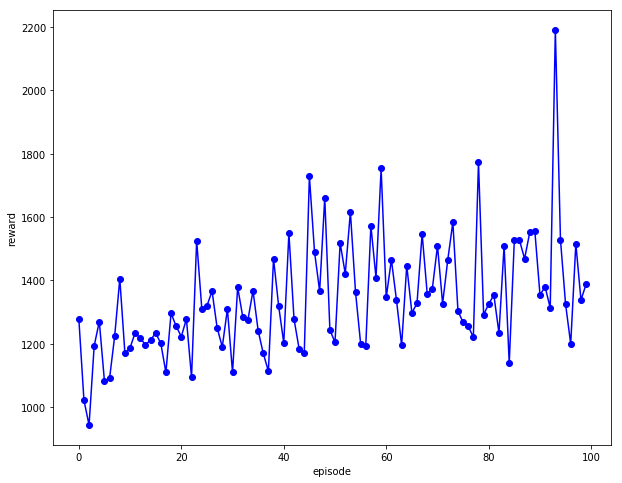

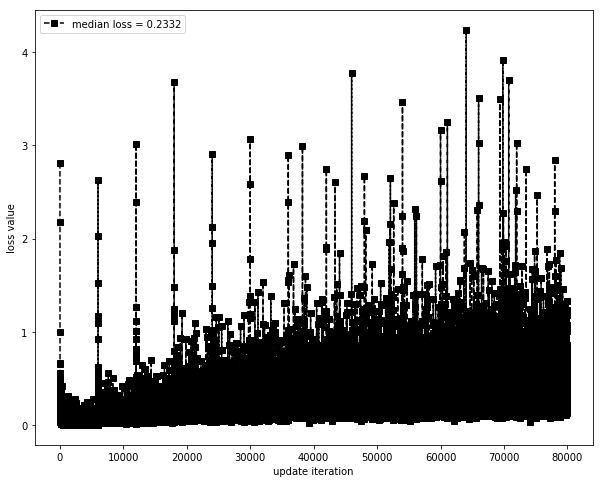

In [22]:
fig = plt.figure()
plt.plot(range(len(rew_hist)), rew_hist, 'b-o')
plt.xlabel('episode')
plt.ylabel('reward')

fig = plt.figure()
plt.plot(range(len(loss_hist)), loss_hist, 'k--s', label="median loss = %0.4f" %(np.median(loss_hist)))
plt.xlabel('update iteration')
plt.ylabel('loss value')
plt.legend()

In [24]:
Q

array([  0.04027338,  18.273592  ,  18.67834854,  15.61604309,
        23.49066734,  16.16426468,  21.94495392,  20.95626259,  19.01459122], dtype=float32)

## test network in simulation

In [25]:
seed = 4

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


seed 004: 86 reward
5.65s = 0.09m elapsed


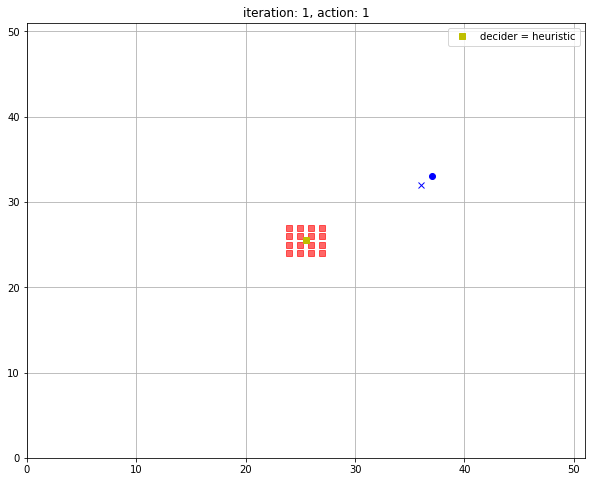

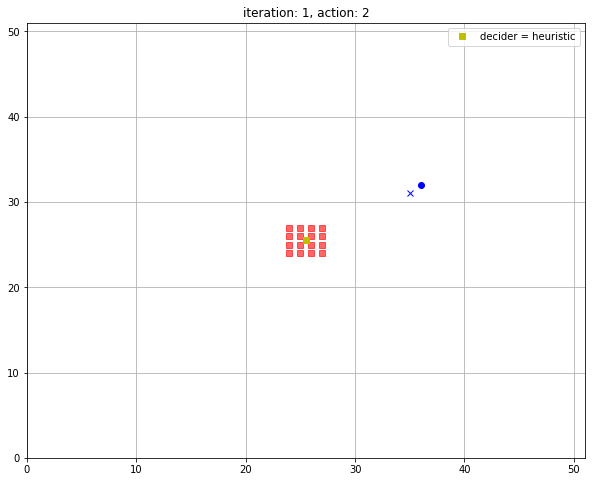

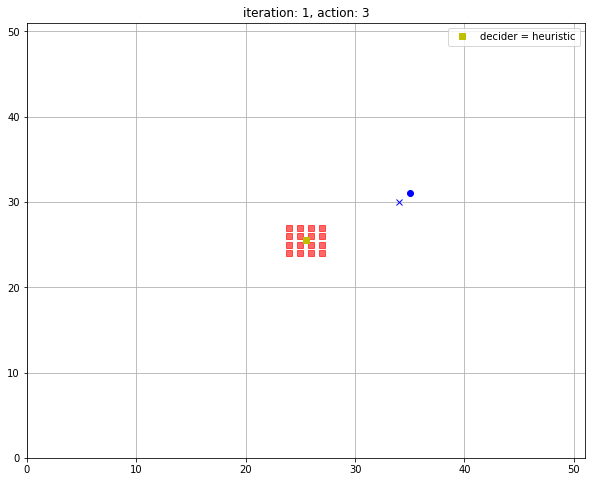

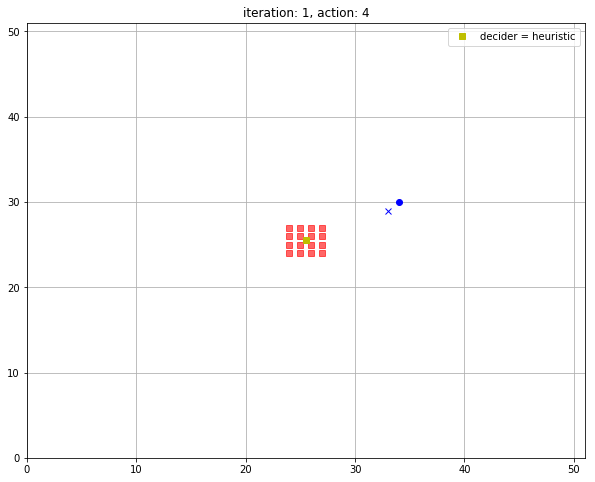

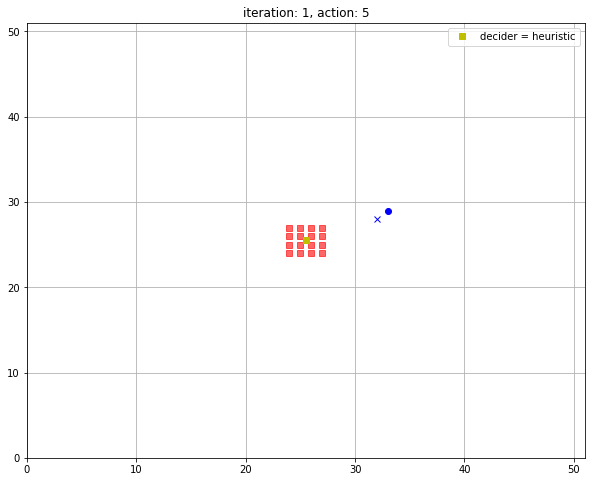

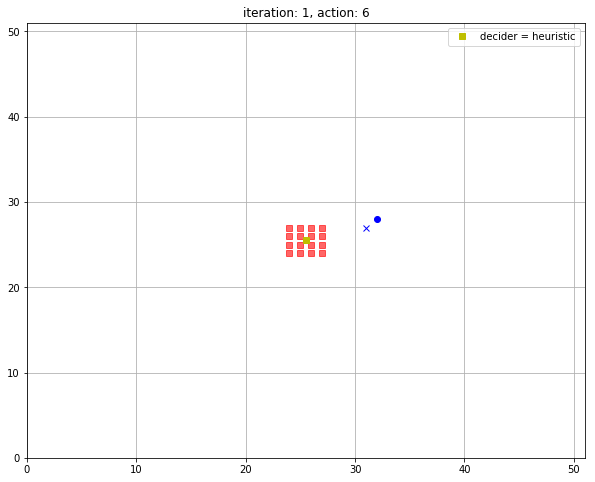

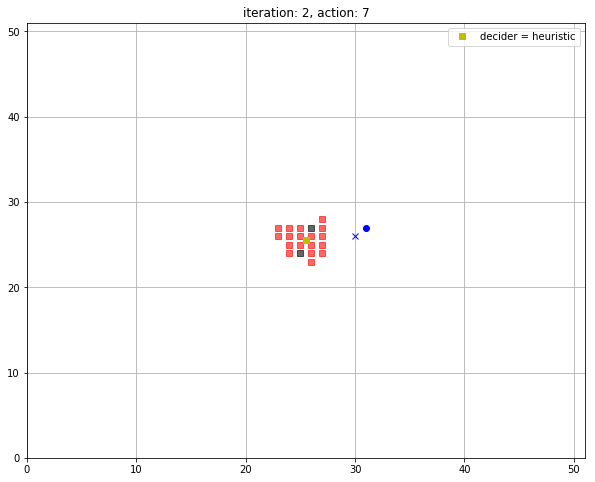

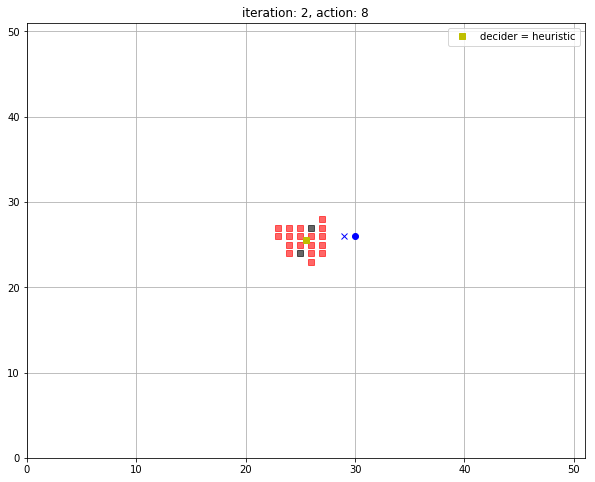

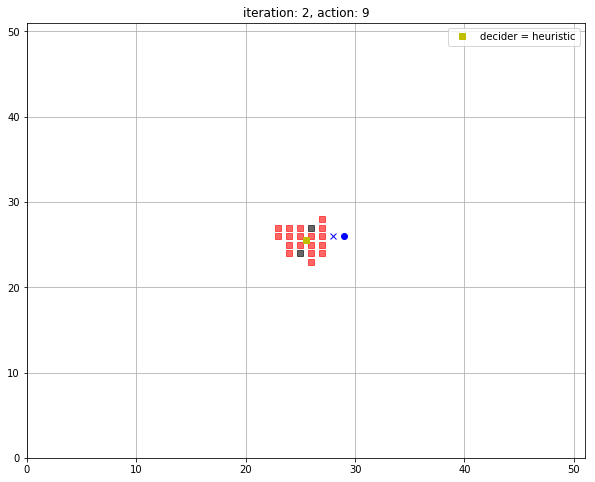

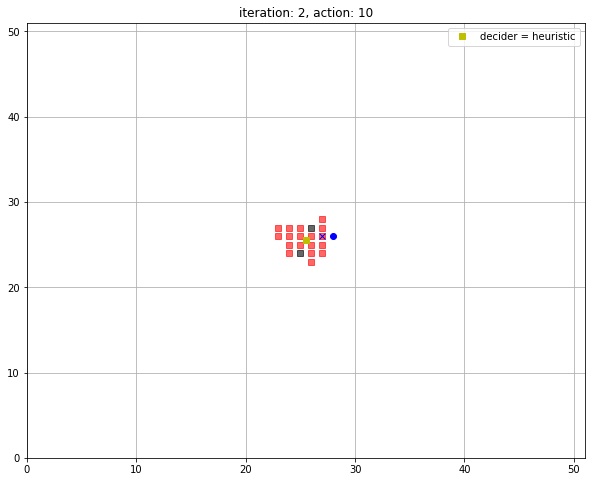

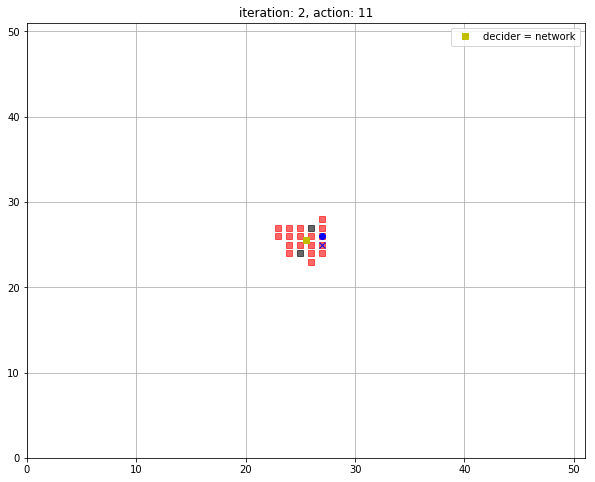

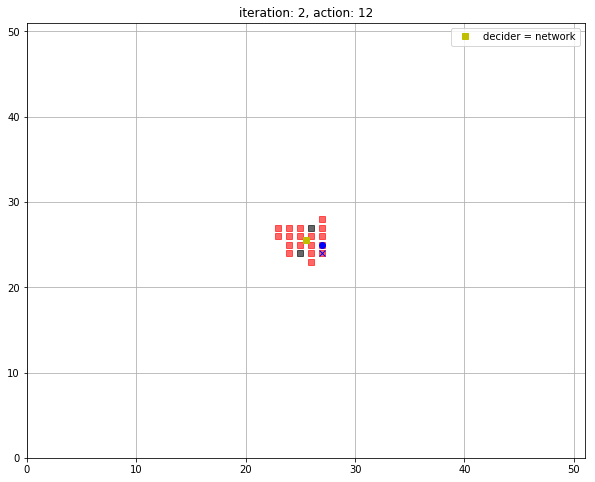

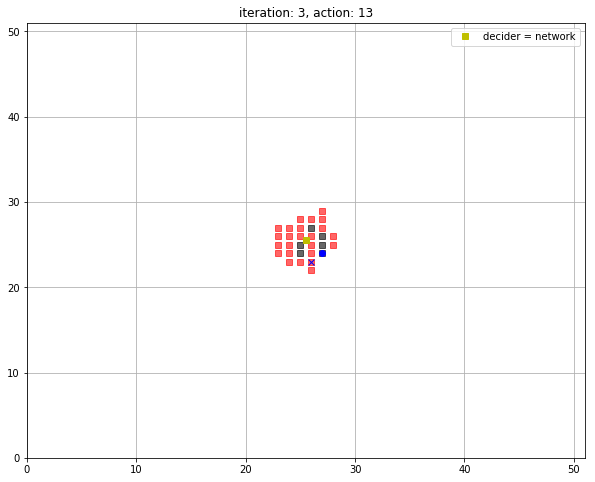

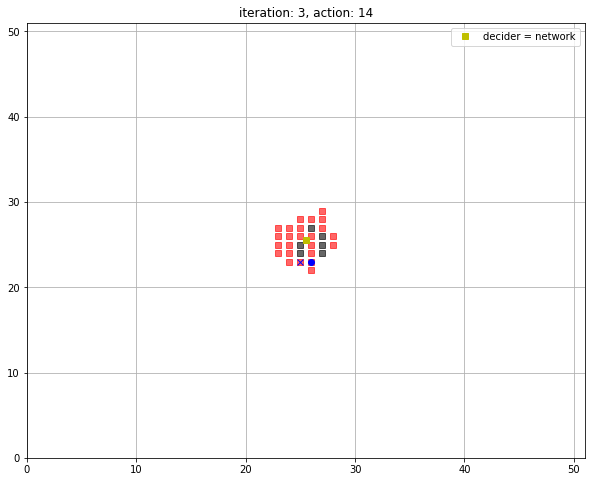

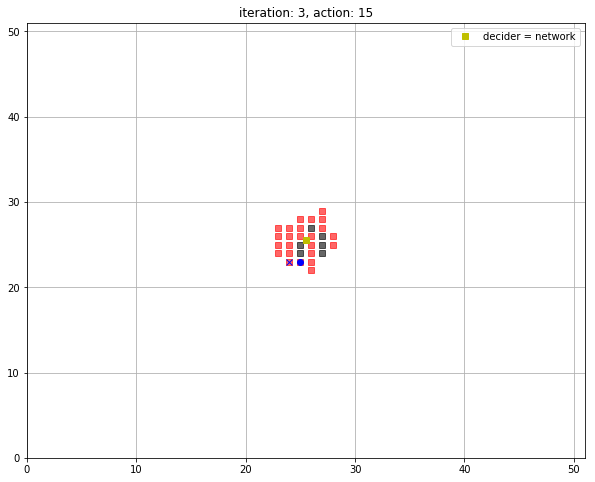

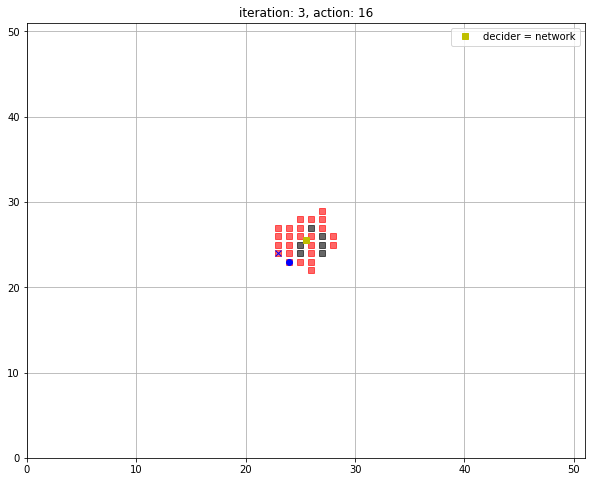

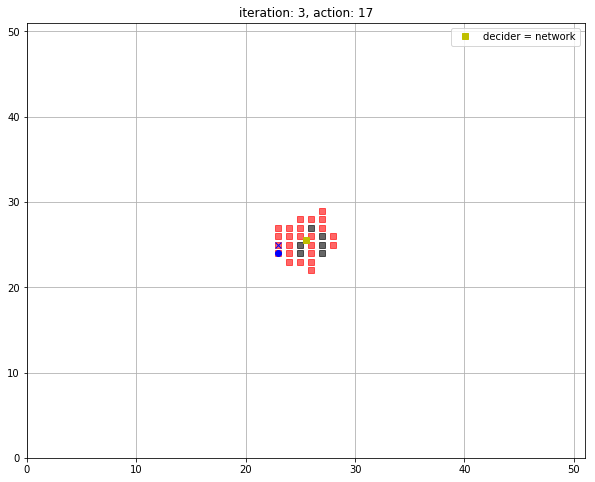

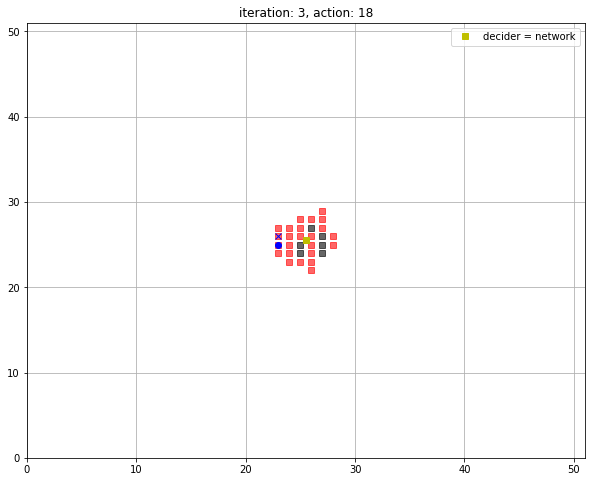

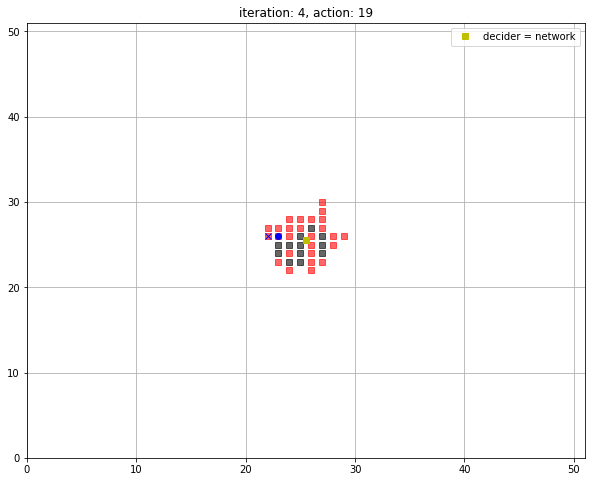

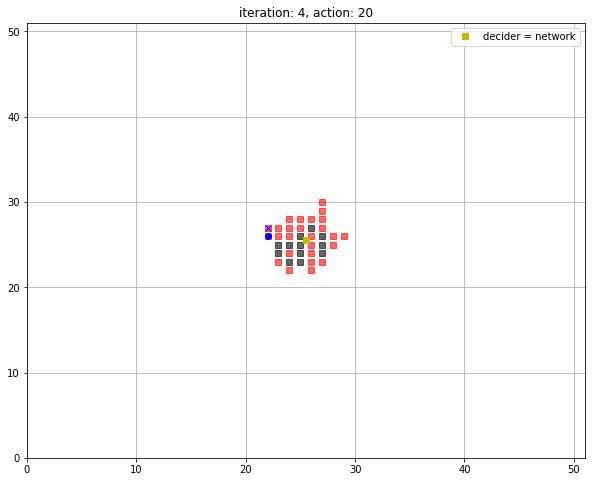

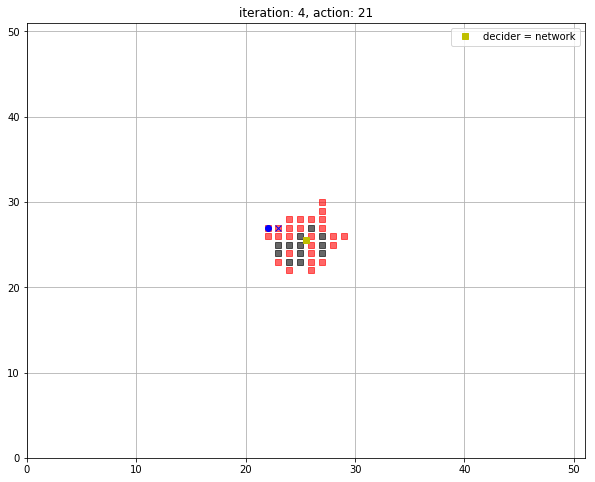

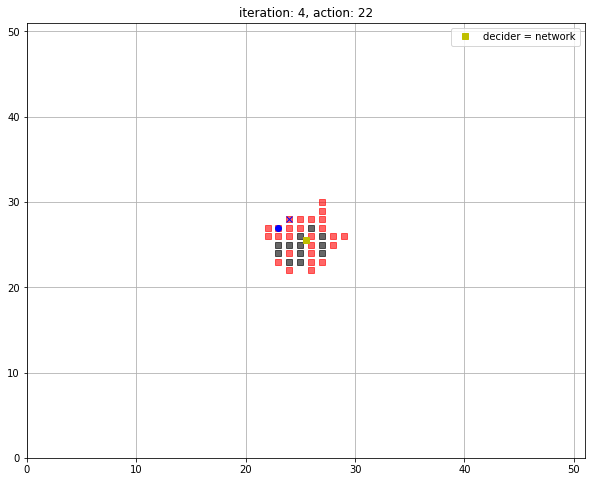

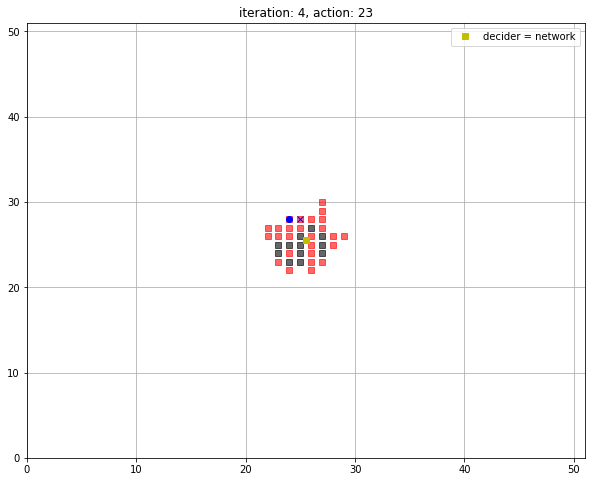

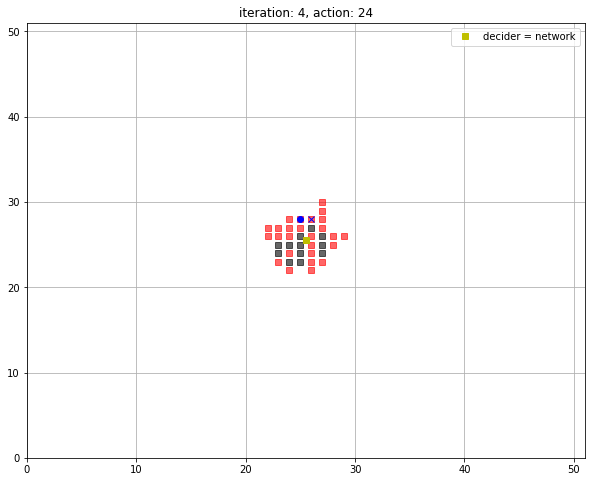

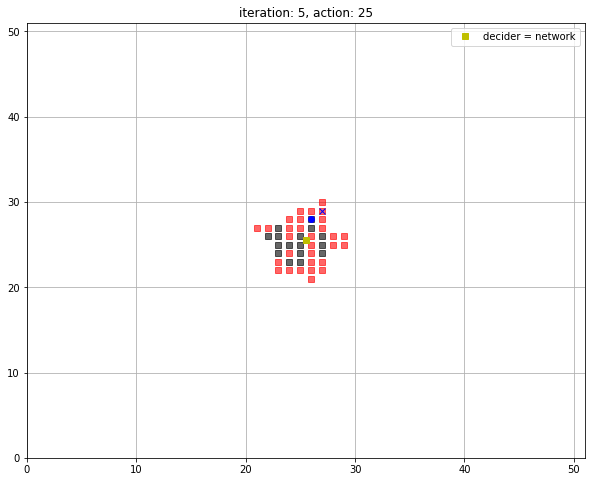

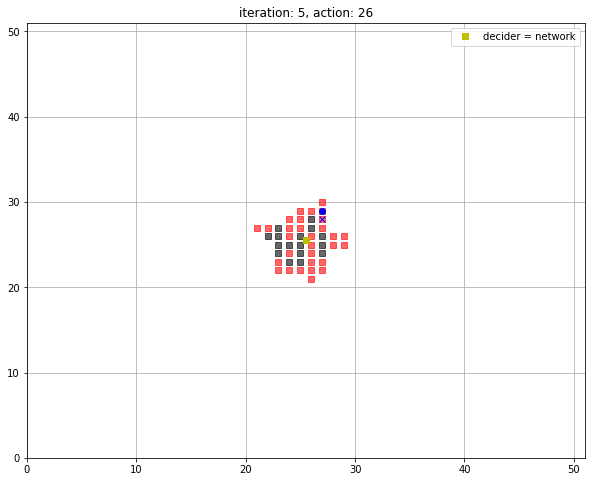

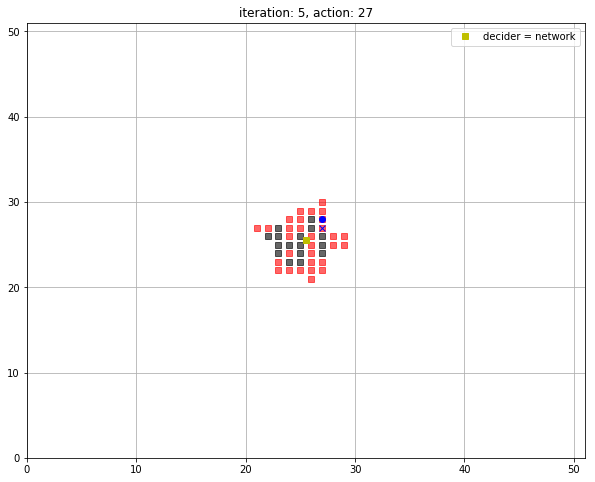

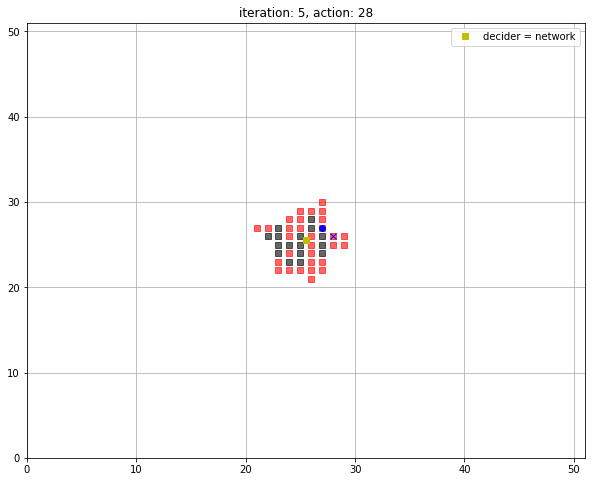

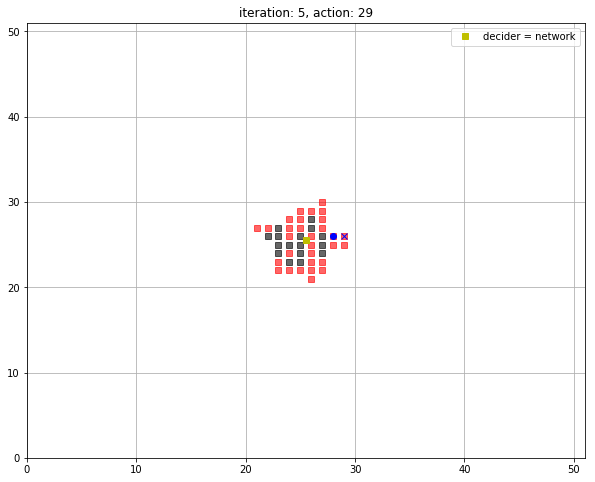

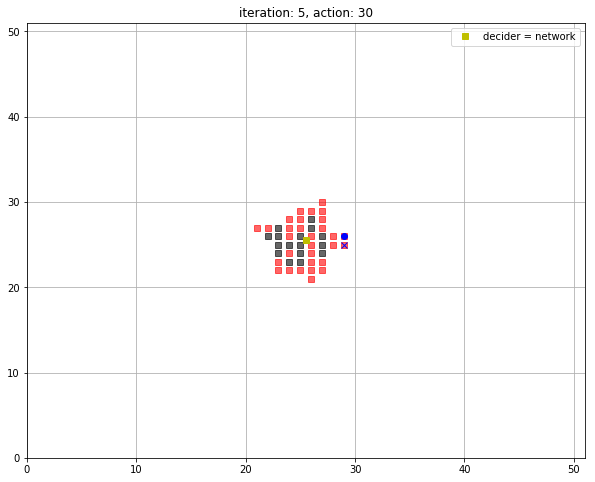

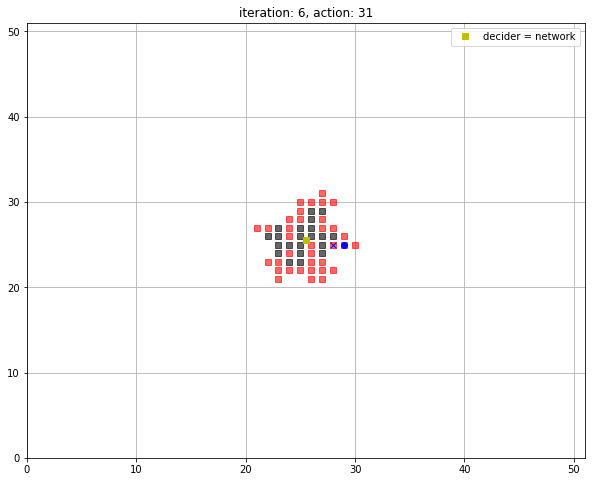

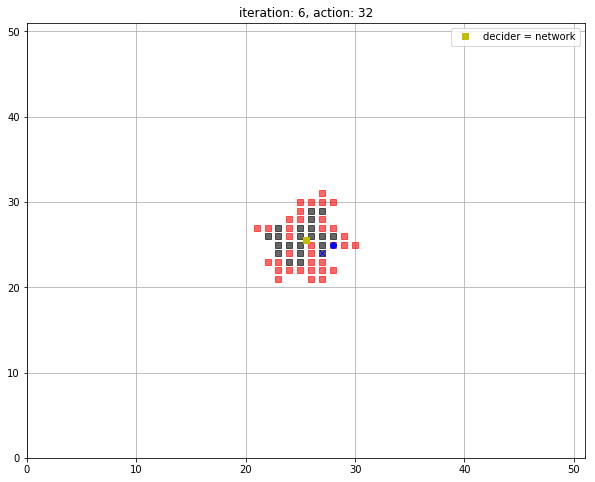

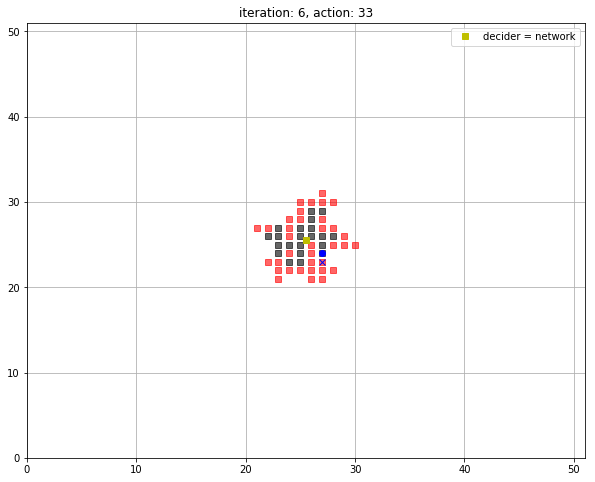

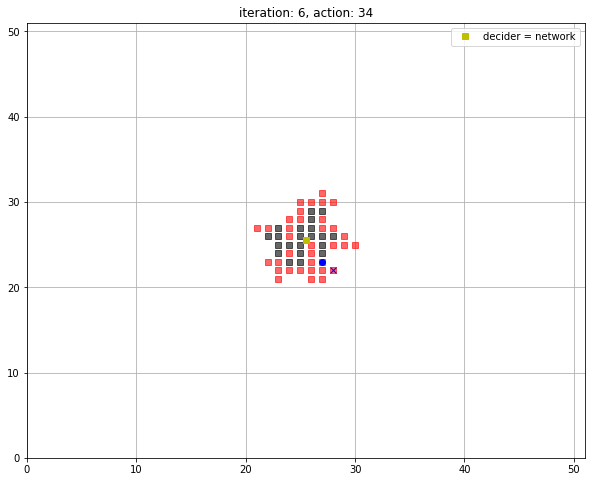

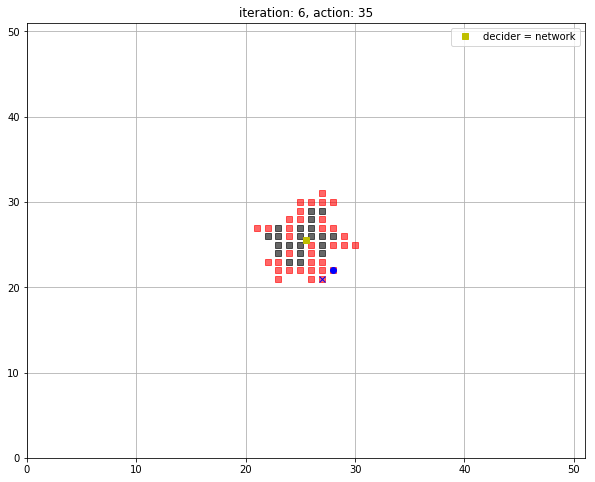

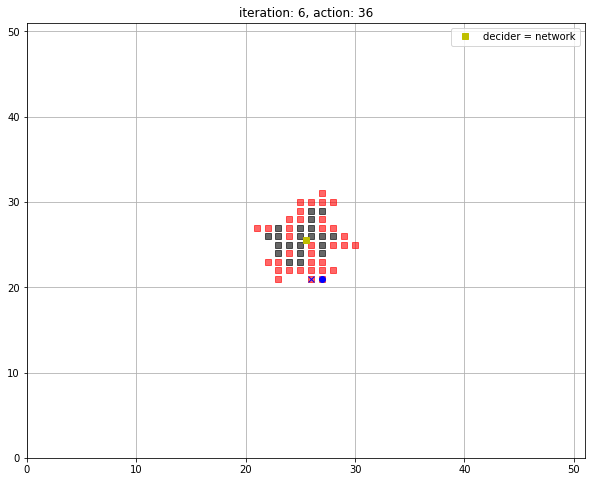

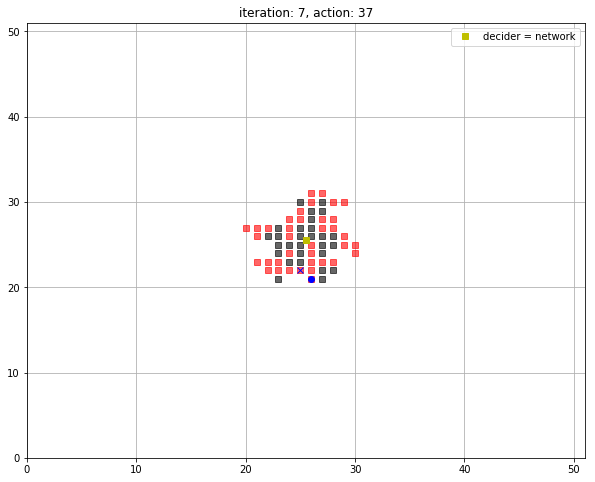

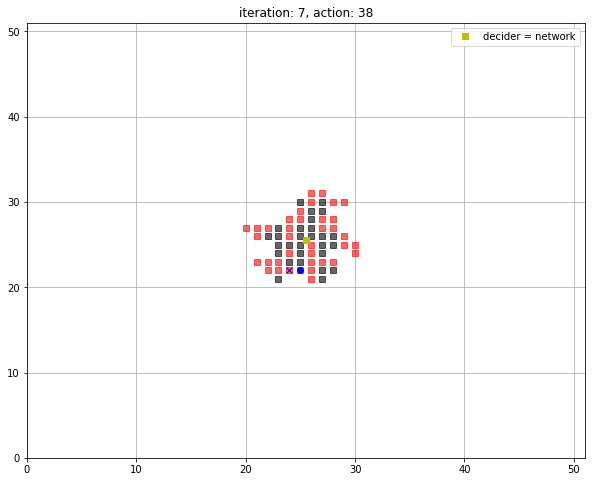

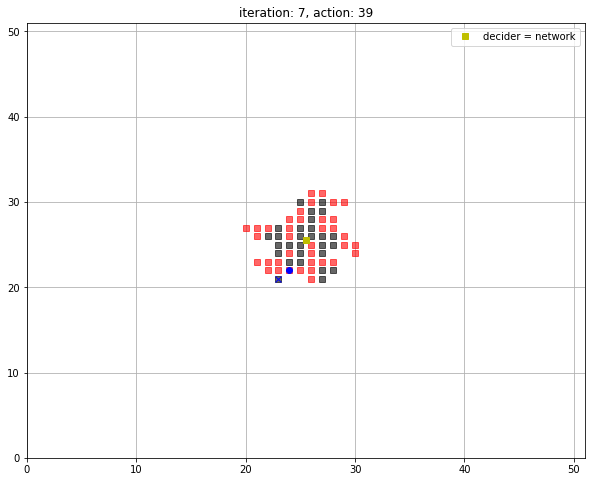

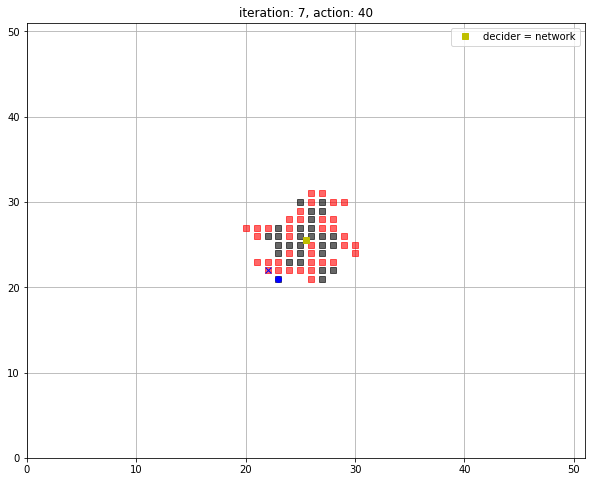

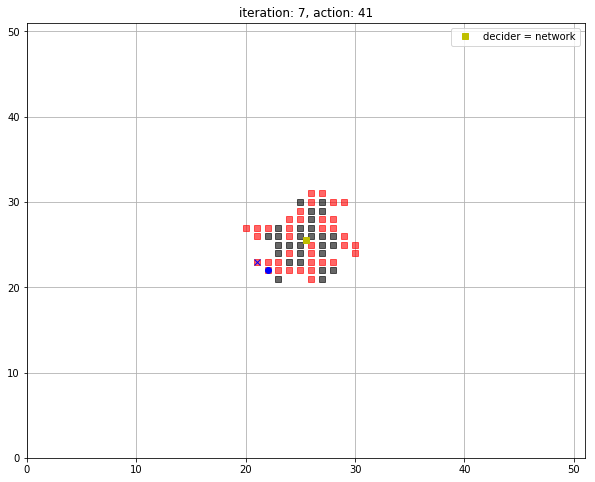

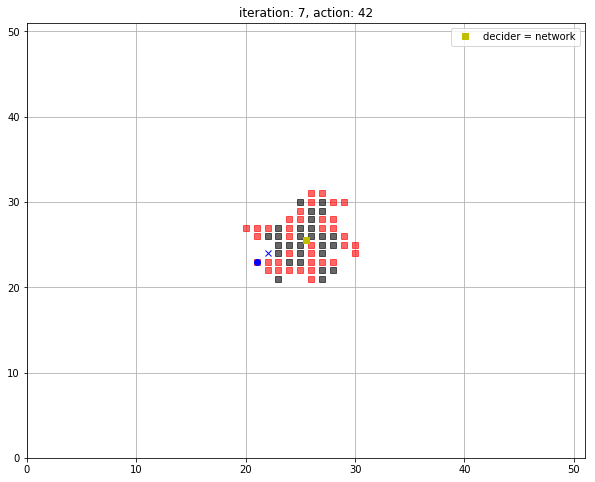

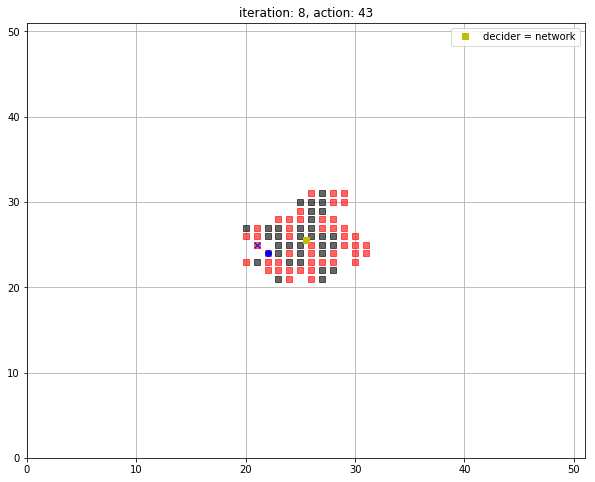

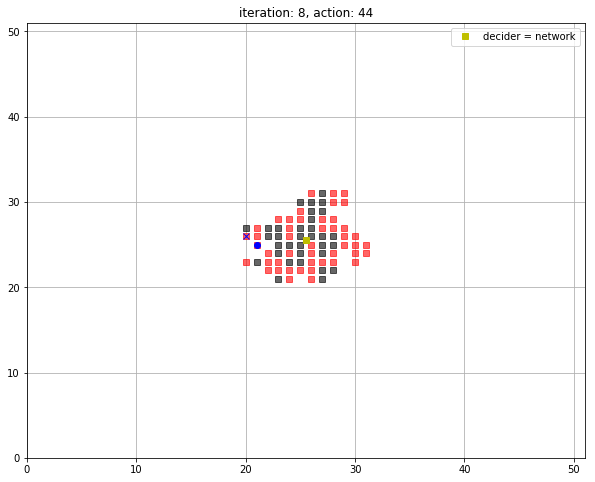

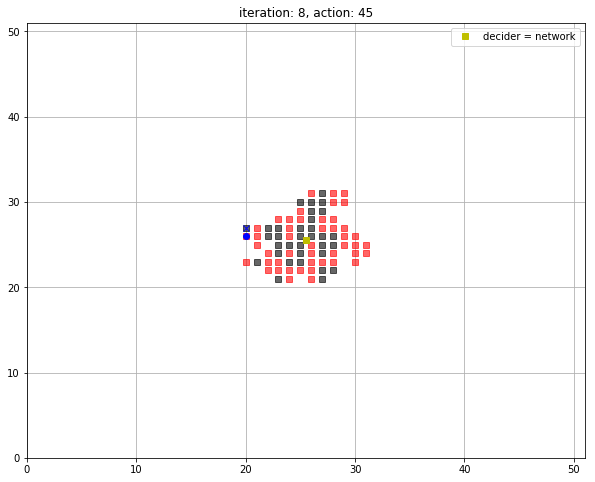

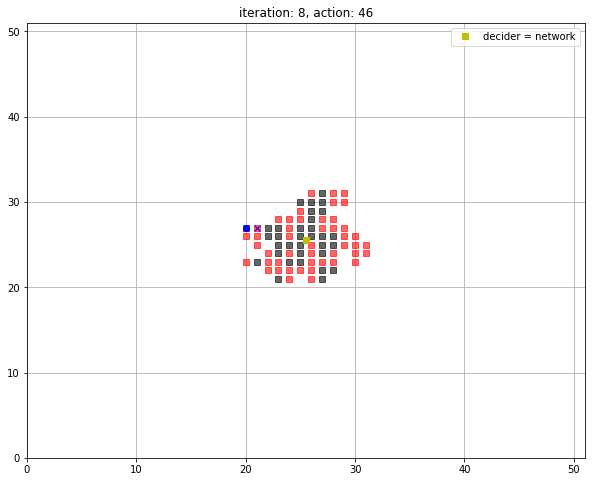

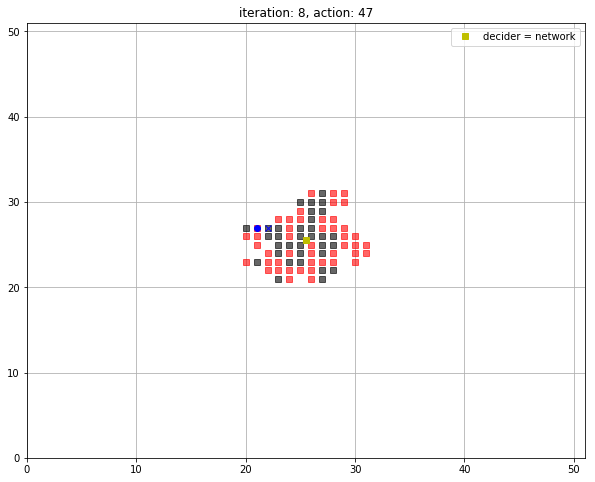

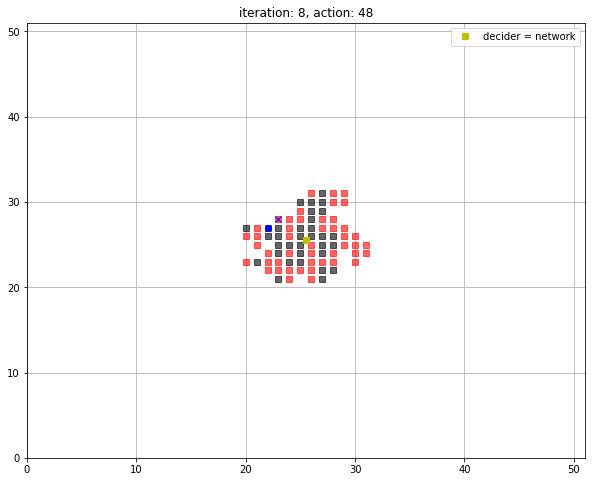

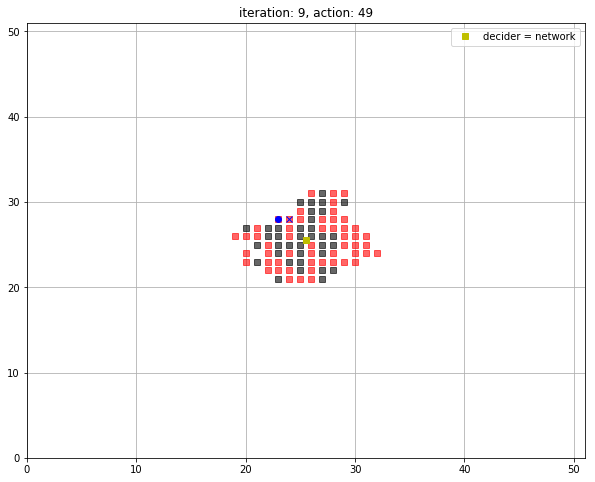

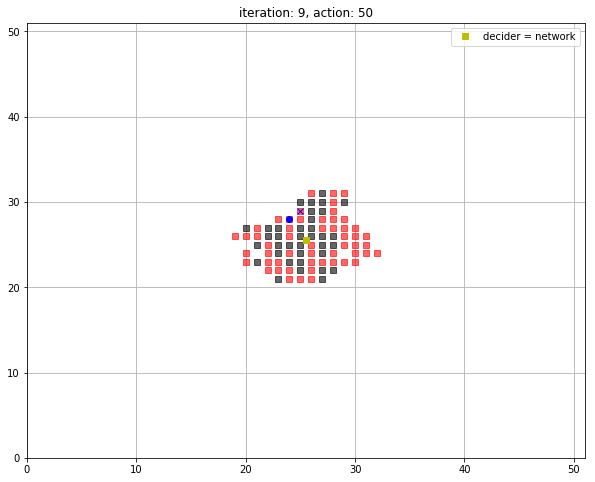

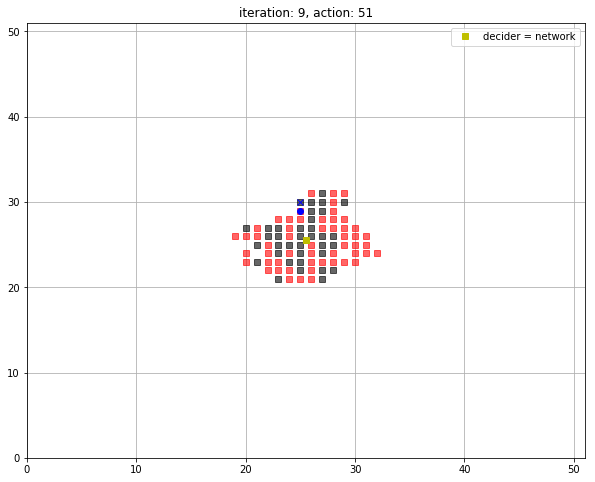

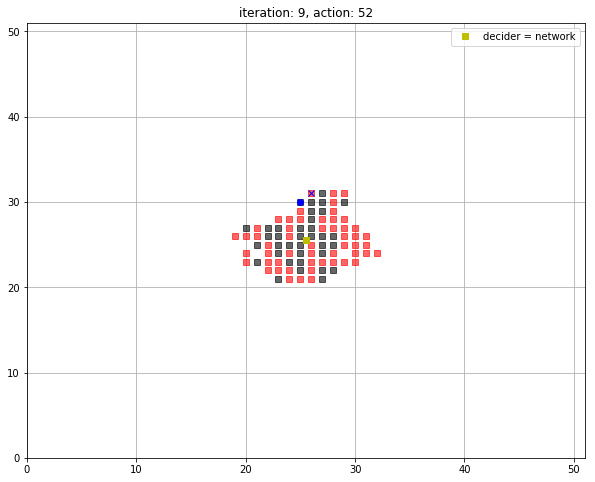

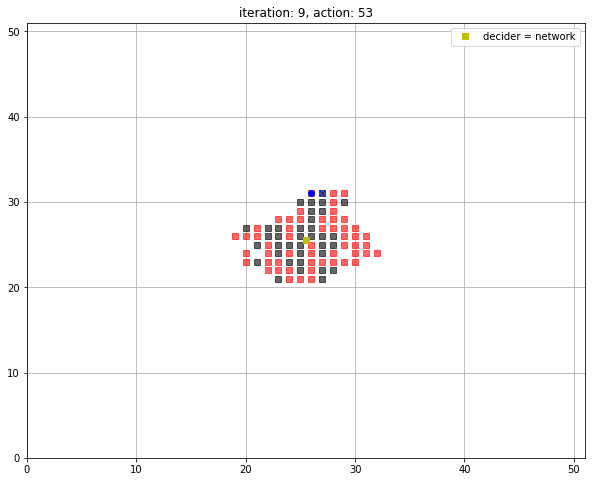

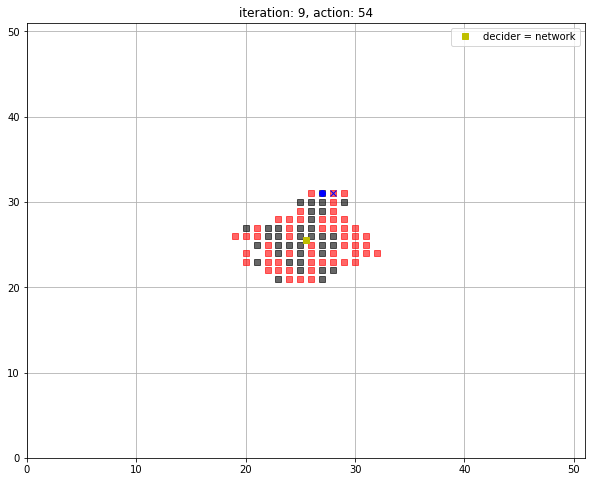

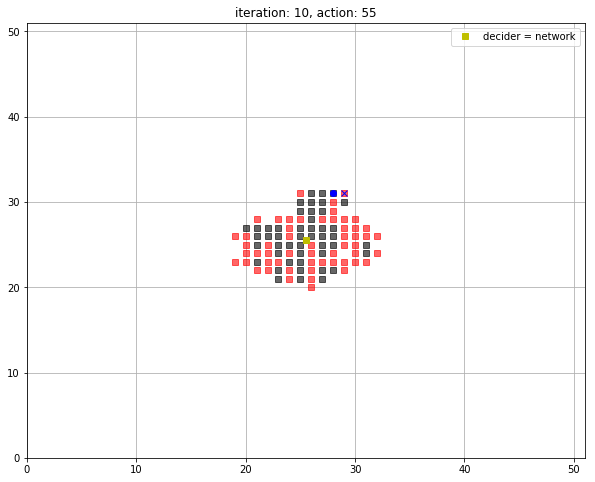

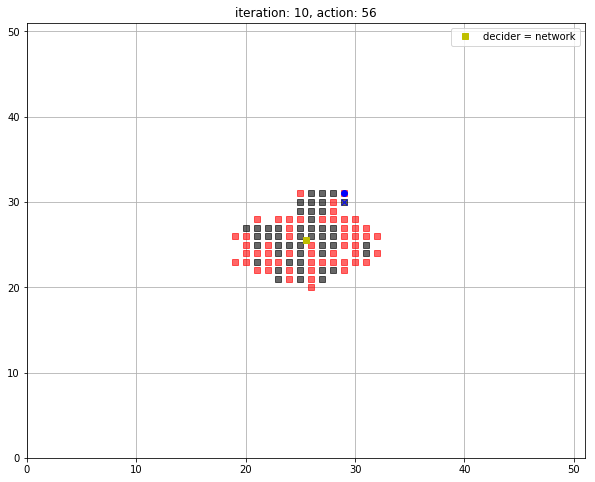

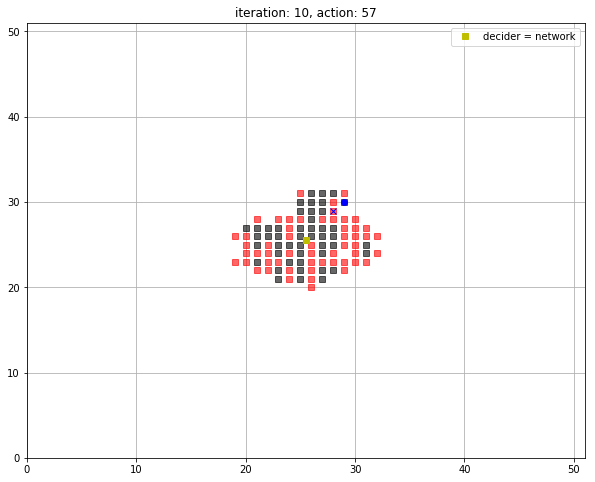

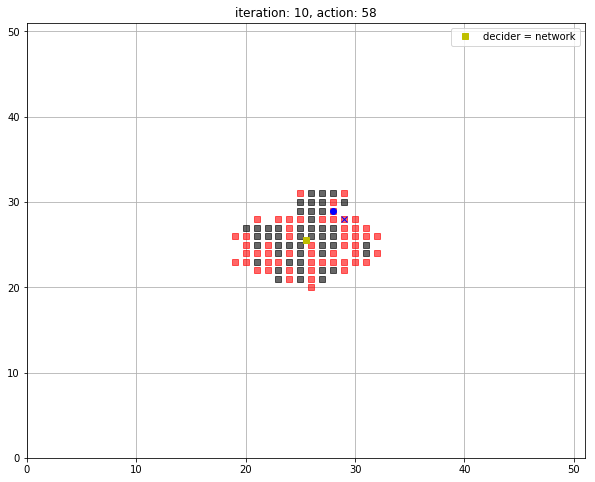

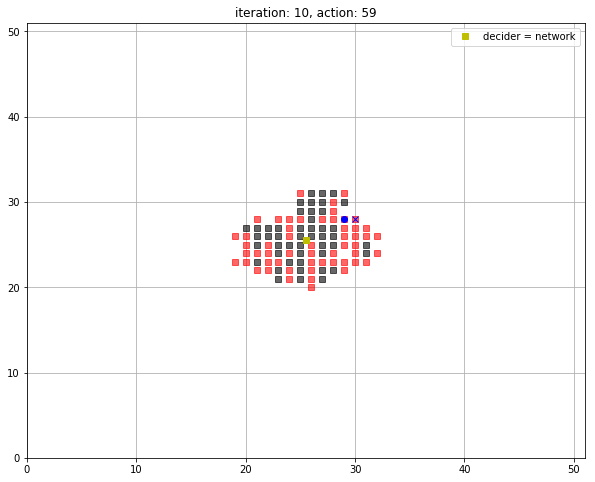

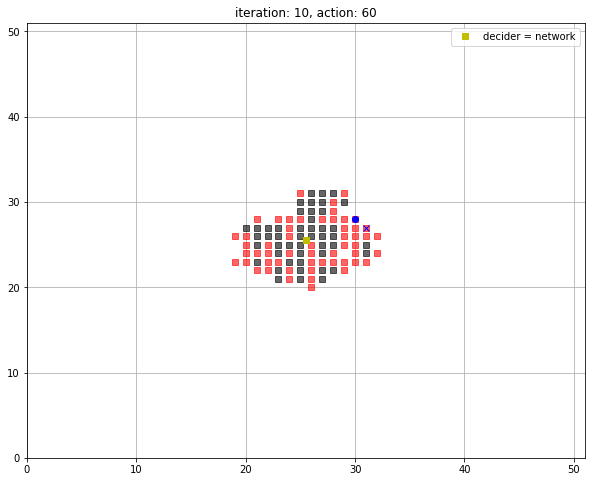

In [26]:
plotting = True
plt.close('all')

tic = time.clock()
# run simulator many times
s = seed
np.random.seed(s)

# initialize simulator
sim = FireSimulator(grid_size, rng=s)
sim.step([]) # start fire in domain

# initialize agent position
n = 1
agent_pos = np.random.choice(spawn_loc, (1,2)) + np.random.choice(perturbs, (n,2))
agent_pos = np.squeeze(agent_pos).astype(np.int32)
agent_sf = False

seed_rew = 0
control = []
repeat_ctr = 1

# while not sim.end:
for _ in range(6*10):
    decision = None
    if plotting:
        plt.figure()
        plt.grid()
        plt.xlim([0,grid_size+1])
        plt.ylim([0,grid_size+1])
        plt.title('iteration: %d, action: %d' % (sim.iter,repeat_ctr))

        #plt.plot(center,center,"gx")
        for i in range(grid_size):
            for j in range(grid_size):
                x = col_to_x(j)
                y = row_to_y(grid_size,i)
                if sim.state[i,j] == 1:
                    plt.plot(x,y,"rs",alpha=0.6)
                elif sim.state[i,j] == 2:
                    plt.plot(x,y,"ks",alpha=0.6)
    
    
    img, img_st, _ = CreateImageBW(sim.state, agent_pos)
    if img_st[8//2,8//2] in [1,2]:
        agent_sf = True
    rot_vec = agent_pos - center
    rot_vec = rot_vec / np.linalg.norm(rot_vec,2)
    rot_vec = np.array([rot_vec[1],-rot_vec[0]])

    # select action by exploration/exploitation
    if not agent_sf:
        #action = np.random.choice(range(9))
        #traj = actions_to_trajectory(agent_pos, [action])

        traj, action, agent_sf = heuristic(agent_pos, img_st, agent_sf, center)
        action = action[0]
        decision = 'heuristic'

    else:
        state = np.concatenate((img[3:6,3:6].reshape((img_dim**2,)), rot_vec))
        state = Variable(torch.from_numpy(state)).type(dtype)
        Q = model(state.unsqueeze(0))[0].data.cpu().numpy()
        action = np.argmax(Q)
        traj = actions_to_trajectory(agent_pos, [action])
        decision = 'network'

    # generate control from trajectory
    control.extend(FindGridIntersections(sim.state, traj)) 
    control = list(set(control))
    
    # calculate reward
    seed_rew += eelfff_reward(traj, img_st, center)
    
    if plotting:
        plt.plot(traj[0][0],traj[0][1],"bo")
        plt.plot(traj[-1][0],traj[-1][1],"bx")

    # update agent location
    agent_pos[:] = [traj[-1][0], traj[-1][1]]

    # update simulator periodically 
    if repeat_ctr % repeat_lim == 0:
        sim.step(control, dbeta=dp)
        control = []
    repeat_ctr += 1
    
    if plotting:
        #plt.plot(center,center,"ys",label='# unique agents = %d' %(len(set(tuple(x) for x in agent_pos))))
        plt.plot(center,center,"ys",label='decider = %s' %(decision))
        plt.legend()

print('seed %03d: %d reward' %(s, seed_rew))
rew_hist.append(seed_rew)
    
toc = time.clock()
print("%0.2fs = %0.2fm elapsed" % (toc-tic,(toc-tic)/60))